In [2]:
# Standard imports 
import numpy as np
import pandas as pd

# OS and time packages 
import os
import time
import tqdm
import concurrent.futures
from pathlib import Path
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# HTML and text processing 
import requests
from bs4 import BeautifulSoup
import json
import re

import time
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

# Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

plt.rc('font', size=14)             # controls default text sizes
plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=14)       # legend fontsize
plt.rc('figure', titlesize=20)      # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

# Filter warnings 
pd.options.mode.chained_assignment = None
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import pyreadr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
import xlrd

C:\Users\JBH\AppData\Local\Temp\ipykernel_100312\2864530101.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
def log(response: requests.Response):
    """
    Creates or appends a log-file with information from a `requests.get()`-call.
    
    The information gathered is:
    - - - - - - - -
        timestamp   :   Current local time.
        status_code :   Status code from requests call.
        length      :   Length of the HTML-string.
        output_path :   Current working directory.
        url         :   The URL of the response.
    """

    # Open or create the csv file
    if os.path.isfile('log'):
        log = open('log','a')
    else: 
        log = open('log','w')
        header = ['timestamp', 'status_code', 'length', 'output_file', 'url'] # Header names
        log.write(';'.join(header) + "\n")
        
    # Gather log information
    status_code = response.status_code # Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) # Local time
    length = len(response.text) # Length of the HTML-string
    output_path = os.getcwd() # Output path
    url = response.url # URL-string
    
    # Open the log file and append the gathered log information
    with open('log','a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path};{url}' + "\n") 

In [4]:
def get_soup(url: str, header: dict, selenium=False, driver=None) -> BeautifulSoup:
    """
    Constructs a HTML-string from a request of the given URL. 
    Requests are logged, see `log()`. 

    Input:
    - - - - - - - - 
    url (str)     :    URL of the website to receive the HTML-string from. \n
    header (dict) :    Dictionary to send in the query string for the request.

    Returns:
    - - - - - - - - 
    soup (BeautifulSoup) :  HTML-string in the class of BeutifulSoup with 'lxml' parser.
    """

    if selenium==True:
        driver.get(url)
        soup=BeautifulSoup(driver.page_source, 'lxml')
    else:
        response = requests.get(url, headers=header) # Request
        log(response) # Log 
        soup = BeautifulSoup(response.content, 'lxml') # Convert to response to HTML
    return soup

In [5]:
def create_url_boliga(page: int, city=None) -> str:
    """
    Creates a boliga URL with the given pagenumber.
    Input:
    - - - - - - - -
    page (int) :    Pagenumber for the boliga website.

    Returns:
    - - - - - - - -
    url (str)  :    URL of the boliga website for given page. 
    """

     # Construct url with f-string
    if city == 'Aarhus':
        url = f'https://www.boliga.dk/salg/resultater?searchTab=1&page={page}&sort=date-a&propertyType=1&salesDateMin=1992&salesDateMax=2015&municipality=751'
    elif city =='Odense':
        url = 'https://www.boliga.dk/salg/resultater?searchTab=1&page={page}&sort=date-a&propertyType=1&salesDateMin=1992&salesDateMax=2015&municipality=461'
    elif city == 'Copenhagen':
        url = 'https://www.boliga.dk/salg/resultater?searchTab=1&page={page}&sort=date-a&propertyType=1&salesDateMin=1992&salesDateMax=2015&municipality=101'
    return url

In [6]:
header = {'name' : 'Jørgen Baun Høst',          'email' : 'pjz633@econ.ku.dk',
          'intention': 'Scrape Boliga for academic purposes'}

In [7]:
def extract_info_boliga(soup:BeautifulSoup) -> pd.DataFrame:
        
    href = soup.find(class_="text-primary font-weight-bolder text-left")['href']
    url = f'https://www.boliga.dk{href}'
    id = re.search(r'[^/]+$', href)[0]
    url_bbr = f'https://www.boliga.dk/bbrinfo/{id}'
    address = soup.find(class_="text-primary font-weight-bolder text-left").text
    price = soup.find(class_="table-col d-print-table-cell text-center").text
    date_of_sale = soup.div.find_all('span')[0].text
    type_of_sale = soup.div.find_all('span')[1].text
    house_size = soup.find(class_='d-flex flex-column').find_all('span')[0].text
    price_per_m2 = soup.find(class_='d-flex flex-column').find_all('span')[1].text
    no_of_rooms = soup.find_all('td')[4].text
    year_built = soup.find_all('td')[5].text

    return [url, url_bbr, address, price, date_of_sale, type_of_sale, house_size, price_per_m2, no_of_rooms, year_built]


In [8]:
column_names = ['link', 'bbr_link', 'address', 'price', 'date_of_sale','type_of_sale', 'house_size_m2', 'house_price_per_m2', 'no_of_rooms', 'year_built']

In [9]:
list_of_url_kbh = []
list_of_url_aar = []
list_of_url_ode = []

for page in range(1, 358+1):
    url = f'https://www.boliga.dk/salg/resultater?searchTab=1&page={page}&sort=date-a&propertyType=1&salesDateMin=1992&salesDateMax=2015&municipality=101'
    list_of_url_kbh.append(url)

for page in range(1, 654+1):
    url = f'https://www.boliga.dk/salg/resultater?searchTab=1&page={page}&sort=date-a&propertyType=1&salesDateMin=1992&salesDateMax=2015&municipality=461'
    list_of_url_ode.append(url)

for page in range(1, 907):
    url = f'https://www.boliga.dk/salg/resultater?searchTab=1&page={page}&sort=date-a&propertyType=1&salesDateMin=1992&salesDateMax=2015&municipality=751'
    list_of_url_aar.append(url)

In [10]:
# errors = []

# def process_url(id_url_pair):
#     id_, url = id_url_pair
#     try:
#         soup = get_soup(url, header)
#         list_of_ads = soup.find_all('tr')
#         output = []

#         for ad in list_of_ads:
#             info = extract_info_boliga(ad)
#             output.append(info)
#         return id_, output
#     except:
#         print(f'Error encountered on url {url}')
#         errors.append(url)
#         pd.DataFrame(errors).to_csv
#         return id_, None

# id_url_pairs = [(id_, url) for id_, url in enumerate(list_of_url_kbh[:20])]

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     results = list(tqdm.tqdm(executor.map(process_url, id_url_pairs), total=len(id_url_pairs)))

# for result in results:
#     id_, data = result
#     output = []
#     if data is not None:
#         output.append(data)
#         df = pd.DataFrame(output[0], columns=column_names)
#         df.to_parquet(f'data/copenhagen/boliga_{id_}.pq')

In [11]:
# errors = []

# def process_url(id_url_pair):
#     id_, url = id_url_pair
#     try:
#         soup = get_soup(url, header)
#         list_of_ads = soup.find_all('tr')
#         output = []

#         for ad in list_of_ads:
#             info = extract_info_boliga(ad)
#             output.append(info)
#         return id_, output
#     except:
#         print(f'Error encountered on url {url}')
#         errors.append(url)
#         pd.DataFrame(errors).to_csv
#         return id_, None

# id_url_pairs = [(id_, url) for id_, url in enumerate(list_of_url_kbh)]


# for id_ in tqdm.tqdm(range(len(id_url_pairs))):
#     id_, data = process_url(id_url_pairs[id_])
#     df = pd.DataFrame(data)
#     df.columns = column_names
#     df.to_parquet(f'data/copenhagen/boliga_v2_{id_}.pq')

In [12]:
# id_url_pairs = [(id_, url) for id_, url in enumerate(list_of_url_aar)]


# for id_ in tqdm.tqdm(range(len(id_url_pairs))):
#     id_, data = process_url(id_url_pairs[id_])
#     df = pd.DataFrame(data)
#     df.columns = column_names
#     df.to_parquet(f'data/aarhus/boliga_v2_{id_}.pq')

In [13]:
# id_url_pairs = [(id_, url) for id_, url in enumerate(list_of_url_ode)]


# for id_ in tqdm.tqdm(range(len(id_url_pairs))):
#     id_, data = process_url(id_url_pairs[id_])
#     df = pd.DataFrame(data)
#     df.columns = column_names
#     df.to_parquet(f'data/odense/boliga_v2_{id_}.pq')

In [14]:
data_dir = Path('C:/Users/JBH/Dropbox/11_semester/Public_Econ_seminar/data/odense')
full_df1 = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('boliga_v2_*.pq')
)

full_df1['kommune']='Odense Kommune'

full_df1.to_parquet('data/odense.pq')

In [15]:
data_dir = Path('C:/Users/JBH/Dropbox/11_semester/Public_Econ_seminar/data/copenhagen')
full_df2 = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('boliga_v2_*.pq')
)

full_df2['kommune']='Københavns Kommune'

full_df2.to_parquet('data/copenhagen.pq')

In [16]:
data_dir = Path('C:/Users/JBH/Dropbox/11_semester/Public_Econ_seminar/data/aarhus')
full_df3 = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('boliga_v2_*.pq')
)
full_df3['kommune']='Aarhus Kommune'
full_df3.to_parquet('data/aarhus.pq')

In [69]:
data_dir = Path('C:/Users/JBH/Dropbox/11_semester/Public_Econ_seminar/data/bbr')
bbrdf1 = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.pq')
)

bbrdf1.to_parquet('data/bbr1.pq')

In [70]:
data_dir = Path('C:/Users/JBH/Dropbox/11_semester/Public_Econ_seminar/data/bbr2')
bbrdf2 = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.pq')
)

bbrdf2.to_parquet('data/bbr2.pq')

In [71]:
data_dir = Path('C:/Users/JBH/Dropbox/11_semester/Public_Econ_seminar/data/bbr3')
bbrdf3 = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.pq')
)

bbrdf3.to_parquet('data/bbr3.pq')

In [74]:
temp=pd.concat([bbrdf1, bbrdf2, bbrdf3])
scraped_bbrs=temp['bbr_link'].unique().tolist()

In [17]:
def extract_info_boliga_bbr_extra(soup:BeautifulSoup) -> pd.DataFrame:
    dwelling_type=soup.find(class_="house-name").text
    dwelling_type2=soup.find_all(class_="col-md-6 column")[0].div.span.text
    dwelling_type3=soup.find_all(class_="col-md-6 column")[2].div.span.text
    kitchen_type=soup.find_all(class_="col-md-6 column")[1].div.span.text
    bathrooms=soup.find_all(class_="col-md-6 column")[5].div.span.text
    toilet_type=soup.find_all(class_="col-md-6 column")[7].div.span.text
    toilets=soup.find_all(class_="col-md-6 column")[9].div.span.text
    return [dwelling_type, dwelling_type2, dwelling_type3, kitchen_type, bathrooms, toilet_type, toilets]


In [18]:
def extract_info_boliga_bbr(soup:BeautifulSoup) -> pd.DataFrame:
    list_ = soup.find_all('td')
    land_values_list = list_[3::5]
    land_values_date_list = list_[0::5]
    land_vals = []
    land_vals_date = []
    for i in range(len(land_values_list)):
        land_vals.append(land_values_list[i].text.lstrip().rstrip())
        land_vals_date.append(land_values_date_list[i].text.lstrip().rstrip())
    return list(zip(land_vals, land_vals_date))


In [76]:
df = pd.concat([full_df1, full_df2, full_df3])
df=df.reset_index(drop=True)
df

,link,bbr_link,address,price,date_of_sale,type_of_sale,house_size_m2,house_price_per_m2,no_of_rooms,year_built,kommune
0,https://www.boliga.dk/salg/info/461/272371/A7A...,https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D...,Mågebakken 106 5250 Odense SV,730.000 kr.,01-01-1992,Fam. Salg,216 m²,3.380 kr/m²,6,1971,Odense Kommune
1,https://www.boliga.dk/salg/info/461/113877/1FD...,https://www.boliga.dk/bbrinfo/1FDEA88C-AB6E-45...,Faaborgvej 47 5250 Odense SV,581.000 kr.,01-01-1992,Alm. Salg,165 m²,3.521 kr/m²,5,1933,Odense Kommune
2,https://www.boliga.dk/salg/info/461/242367/929...,https://www.boliga.dk/bbrinfo/929C81F2-5EC6-40...,Lupinvej 38B 5210 Odense NV,747.646 kr.,01-01-1992,Alm. Salg,145 m²,5.156 kr/m²,4,1961,Odense Kommune
3,https://www.boliga.dk/salg/info/461/363539/54F...,https://www.boliga.dk/bbrinfo/54F72ED9-39E7-40...,Slettensvej 127 5270 Odense N,700.000 kr.,02-01-1992,Alm. Salg,257 m²,2.724 kr/m²,11,1910,Odense Kommune
4,https://www.boliga.dk/salg/info/461/150071/80C...,https://www.boliga.dk/bbrinfo/80CB7122-1BB6-4D...,Hannerupgårdsvej 16 5230 Odense M,810.000 kr.,04-01-1992,Alm. Salg,173 m²,4.682 kr/m²,7,1956,Odense Kommune
...,...,...,...,...,...,...,...,...,...,...,...
95842,https://www.boliga.dk/salg/info/751/137532/16B...,https://www.boliga.dk/bbrinfo/16B202CA-2237-42...,Granbakken 8 8520 Lystrup,480.000 kr.,19-07-1994,Alm. Salg,210 m²,2.286 kr/m²,6,1965,Aarhus Kommune
95843,https://www.boliga.dk/salg/info/751/559992/48A...,https://www.boliga.dk/bbrinfo/48A59014-5A94-41...,Østergårdsvej 267 8355 Solbjerg,351.000 kr.,19-07-1994,Alm. Salg,186 m²,1.887 kr/m²,7,1900,Aarhus Kommune
95844,https://www.boliga.dk/salg/info/751/272936/FE2...,https://www.boliga.dk/bbrinfo/FE2160A5-CFBF-41...,Langeløkke 19 8381 Tilst,920.000 kr.,19-07-1994,Alm. Salg,128 m²,7.188 kr/m²,4,1965,Aarhus Kommune
95845,https://www.boliga.dk/salg/info/751/884168/01D...,https://www.boliga.dk/bbrinfo/01D488AA-9B45-4A...,Lerbjerg 26 8381 Tilst,274.500 kr.,20-07-1994,Alm. Salg,138 m²,1.989 kr/m²,5,1994,Aarhus Kommune


In [78]:
og_bbr=df['bbr_link'].unique().tolist()

In [79]:
to_scrape = [item for item in og_bbr if item not in scraped_bbrs]
to_scrape

['https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D59-AF2E-1C641F4BA09F',
 'https://www.boliga.dk/bbrinfo/1FDEA88C-AB6E-4514-9A8E-ACA21B076A79',
 'https://www.boliga.dk/bbrinfo/929C81F2-5EC6-40B5-AE72-1EFA4750A62E',
 'https://www.boliga.dk/bbrinfo/54F72ED9-39E7-4004-9266-5AC25DF22B3D',
 'https://www.boliga.dk/bbrinfo/80CB7122-1BB6-4D81-9311-E370C69FE439',
 'https://www.boliga.dk/bbrinfo/7BD09520-E2C7-4EEF-906E-8A8BDD9245DC',
 'https://www.boliga.dk/bbrinfo/9E361121-1902-4C89-B5CD-07116040EAFB',
 'https://www.boliga.dk/bbrinfo/52C89739-BAD1-48E4-A1F2-3401B1D405B9',
 'https://www.boliga.dk/bbrinfo/DE94A86F-61A3-4A53-B83F-F772D3B90DBD',
 'https://www.boliga.dk/bbrinfo/19883EFD-7FA0-4E17-98A3-44670A41B572',
 'https://www.boliga.dk/bbrinfo/38B2A8B8-FE33-45BE-A584-B504B7AC7FB7',
 'https://www.boliga.dk/bbrinfo/4AD84873-D7BB-4FBF-BC7A-A2DA563C4004',
 'https://www.boliga.dk/bbrinfo/8EC6E133-683D-4F80-870B-D732EFA4496A',
 'https://www.boliga.dk/bbrinfo/34EFCCF9-A098-4DCB-B62C-F506FAEFC454',
 'http

In [84]:
to_scrape_df=pd.DataFrame(to_scrape, columns=['bbr_link'])
to_scrape_df.to_parquet('to_scrape.pq')

In [20]:
df['price']=df['price'].str.replace(r'[.]|kr[.]','')
df['price']=df['price'].astype(int)
df['date_of_sale']=pd.to_datetime(df['date_of_sale'])
df['year']=df.date_of_sale.dt.year
df['month']=df.date_of_sale.dt.month
df['week']=df.date_of_sale.dt.week
df['day']=df.date_of_sale.dt.day
df['quarter']=df.date_of_sale.dt.quarter
df['type_of_sale']=df['type_of_sale'].astype('category')
df['house_price_per_m2']=df['house_price_per_m2'].str.replace('kr/m²', '')
df['house_price_per_m2']=df['house_price_per_m2'].str.replace(r'[.]', '')
df['house_size_m2']=df['house_size_m2'].str.strip()
df['house_size_m2']=df['house_size_m2'].str.replace('m²', '')
df['house_size_m2']=df['house_size_m2'].str.replace(r'[.]', '')
df['house_size_m2']=df['house_size_m2'].astype(int)
df['house_price_per_m2']=df['house_price_per_m2'].str.strip()
df['house_price_per_m2']=df['house_price_per_m2'].astype(int)
df['no_of_rooms']=df['no_of_rooms'].astype(int)
df['year_built']=df['year_built'].astype(int)
df['time_q']=pd.PeriodIndex(df['date_of_sale'], freq='Q')
df['address']=df['address'].str.rstrip()
df['address']=df['address'].str.lstrip()

C:\Users\JBH\AppData\Local\Temp\ipykernel_100312\1597275110.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price']=df['price'].str.replace(r'[.]|kr[.]','')
C:\Users\JBH\AppData\Local\Temp\ipykernel_100312\1597275110.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date_of_sale']=pd.to_datetime(df['date_of_sale'])
C:\Users\JBH\AppData\Local\Temp\ipykernel_100312\1597275110.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week']=df.date_of_sale.dt.week
C:\Users\JBH\AppData\Local\Temp\ipykernel_100312\1597275110.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['house_price_per_m2']=df['house_price_per_m2'].str.replace(r'[.]', '')
C:\User

In [21]:
df

,link,bbr_link,address,price,date_of_sale,type_of_sale,house_size_m2,house_price_per_m2,no_of_rooms,year_built,kommune,year,month,week,day,quarter,time_q
0,https://www.boliga.dk/salg/info/461/272371/A7A...,https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D...,Mågebakken 106 5250 Odense SV,730000,1992-01-01,Fam. Salg,216,3380,6,1971,Odense Kommune,1992,1,1,1,1,1992Q1
1,https://www.boliga.dk/salg/info/461/113877/1FD...,https://www.boliga.dk/bbrinfo/1FDEA88C-AB6E-45...,Faaborgvej 47 5250 Odense SV,581000,1992-01-01,Alm. Salg,165,3521,5,1933,Odense Kommune,1992,1,1,1,1,1992Q1
2,https://www.boliga.dk/salg/info/461/242367/929...,https://www.boliga.dk/bbrinfo/929C81F2-5EC6-40...,Lupinvej 38B 5210 Odense NV,747646,1992-01-01,Alm. Salg,145,5156,4,1961,Odense Kommune,1992,1,1,1,1,1992Q1
3,https://www.boliga.dk/salg/info/461/363539/54F...,https://www.boliga.dk/bbrinfo/54F72ED9-39E7-40...,Slettensvej 127 5270 Odense N,700000,1992-02-01,Alm. Salg,257,2724,11,1910,Odense Kommune,1992,2,5,1,1,1992Q1
4,https://www.boliga.dk/salg/info/461/150071/80C...,https://www.boliga.dk/bbrinfo/80CB7122-1BB6-4D...,Hannerupgårdsvej 16 5230 Odense M,810000,1992-04-01,Alm. Salg,173,4682,7,1956,Odense Kommune,1992,4,14,1,2,1992Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95842,https://www.boliga.dk/salg/info/751/137532/16B...,https://www.boliga.dk/bbrinfo/16B202CA-2237-42...,Granbakken 8 8520 Lystrup,480000,1994-07-19,Alm. Salg,210,2286,6,1965,Aarhus Kommune,1994,7,29,19,3,1994Q3
95843,https://www.boliga.dk/salg/info/751/559992/48A...,https://www.boliga.dk/bbrinfo/48A59014-5A94-41...,Østergårdsvej 267 8355 Solbjerg,351000,1994-07-19,Alm. Salg,186,1887,7,1900,Aarhus Kommune,1994,7,29,19,3,1994Q3
95844,https://www.boliga.dk/salg/info/751/272936/FE2...,https://www.boliga.dk/bbrinfo/FE2160A5-CFBF-41...,Langeløkke 19 8381 Tilst,920000,1994-07-19,Alm. Salg,128,7188,4,1965,Aarhus Kommune,1994,7,29,19,3,1994Q3
95845,https://www.boliga.dk/salg/info/751/884168/01D...,https://www.boliga.dk/bbrinfo/01D488AA-9B45-4A...,Lerbjerg 26 8381 Tilst,274500,1994-07-20,Alm. Salg,138,1989,5,1994,Aarhus Kommune,1994,7,29,20,3,1994Q3


In [22]:
regex = r'\d{4}\s[A-Za-zÆØÅæøå\s]+'
df['post_no_city']=df['address'].apply(lambda x: re.findall(regex, x)[0] if re.findall(regex, x) else '')
regex = r'\d{4}'
df['post_no']=df['address'].apply(lambda x: re.findall(regex, x)[0] if re.findall(regex, x) else '')
df['post_no']=df['post_no'].astype(int)
regex = r'\d{4}(.+)'
df['city']=df['post_no_city'].apply(lambda x: re.findall(regex, x)[0] if re.findall(regex, x) else '')
df['city']=df['city'].str.lstrip()
df['city']=df['post_no_city'].apply(lambda x: re.findall(regex, x)[0] if re.findall(regex, x) else '')
df['city']=df['city'].str.lstrip()
df

,link,bbr_link,address,price,date_of_sale,type_of_sale,house_size_m2,house_price_per_m2,no_of_rooms,year_built,kommune,year,month,week,day,quarter,time_q,post_no_city,post_no,city
0,https://www.boliga.dk/salg/info/461/272371/A7A...,https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D...,Mågebakken 106 5250 Odense SV,730000,1992-01-01,Fam. Salg,216,3380,6,1971,Odense Kommune,1992,1,1,1,1,1992Q1,5250 Odense SV,5250,Odense SV
1,https://www.boliga.dk/salg/info/461/113877/1FD...,https://www.boliga.dk/bbrinfo/1FDEA88C-AB6E-45...,Faaborgvej 47 5250 Odense SV,581000,1992-01-01,Alm. Salg,165,3521,5,1933,Odense Kommune,1992,1,1,1,1,1992Q1,5250 Odense SV,5250,Odense SV
2,https://www.boliga.dk/salg/info/461/242367/929...,https://www.boliga.dk/bbrinfo/929C81F2-5EC6-40...,Lupinvej 38B 5210 Odense NV,747646,1992-01-01,Alm. Salg,145,5156,4,1961,Odense Kommune,1992,1,1,1,1,1992Q1,5210 Odense NV,5210,Odense NV
3,https://www.boliga.dk/salg/info/461/363539/54F...,https://www.boliga.dk/bbrinfo/54F72ED9-39E7-40...,Slettensvej 127 5270 Odense N,700000,1992-02-01,Alm. Salg,257,2724,11,1910,Odense Kommune,1992,2,5,1,1,1992Q1,5270 Odense N,5270,Odense N
4,https://www.boliga.dk/salg/info/461/150071/80C...,https://www.boliga.dk/bbrinfo/80CB7122-1BB6-4D...,Hannerupgårdsvej 16 5230 Odense M,810000,1992-04-01,Alm. Salg,173,4682,7,1956,Odense Kommune,1992,4,14,1,2,1992Q2,5230 Odense M,5230,Odense M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95842,https://www.boliga.dk/salg/info/751/137532/16B...,https://www.boliga.dk/bbrinfo/16B202CA-2237-42...,Granbakken 8 8520 Lystrup,480000,1994-07-19,Alm. Salg,210,2286,6,1965,Aarhus Kommune,1994,7,29,19,3,1994Q3,8520 Lystrup,8520,Lystrup
95843,https://www.boliga.dk/salg/info/751/559992/48A...,https://www.boliga.dk/bbrinfo/48A59014-5A94-41...,Østergårdsvej 267 8355 Solbjerg,351000,1994-07-19,Alm. Salg,186,1887,7,1900,Aarhus Kommune,1994,7,29,19,3,1994Q3,8355 Solbjerg,8355,Solbjerg
95844,https://www.boliga.dk/salg/info/751/272936/FE2...,https://www.boliga.dk/bbrinfo/FE2160A5-CFBF-41...,Langeløkke 19 8381 Tilst,920000,1994-07-19,Alm. Salg,128,7188,4,1965,Aarhus Kommune,1994,7,29,19,3,1994Q3,8381 Tilst,8381,Tilst
95845,https://www.boliga.dk/salg/info/751/884168/01D...,https://www.boliga.dk/bbrinfo/01D488AA-9B45-4A...,Lerbjerg 26 8381 Tilst,274500,1994-07-20,Alm. Salg,138,1989,5,1994,Aarhus Kommune,1994,7,29,20,3,1994Q3,8381 Tilst,8381,Tilst


In [23]:
df = df[df['type_of_sale']=='Alm. Salg']
df['price_1000']=df['price']/1000
df = df[df['price']<15_000_000]
df.columns

Index(['link', 'bbr_link', 'address', 'price', 'date_of_sale', 'type_of_sale',
       'house_size_m2', 'house_price_per_m2', 'no_of_rooms', 'year_built',
       'kommune', 'year', 'month', 'week', 'day', 'quarter', 'time_q',
       'post_no_city', 'post_no', 'city', 'price_1000'],
      dtype='object')

In [24]:
land_tax = pd.read_excel('data/kmn_grundskyldspromille.xlsx')
land_tax['year']=pd.to_datetime(land_tax['year'], format='%Y').dt.year
land_tax

,kommune,year,land_tax
0,Københavns Kommune,1993,34.00
1,Odense Kommune,1993,12.90
2,Aarhus Kommune,1993,18.90
3,Københavns Kommune,1994,34.00
4,Odense Kommune,1994,12.90
...,...,...,...
85,Odense Kommune,2021,21.71
86,Aarhus Kommune,2021,24.58
87,Københavns Kommune,2022,34.00
88,Odense Kommune,2022,21.71


In [25]:
house_price_index = pd.read_excel('data/house_price_index.xlsx')
house_price_index['time_q']=pd.PeriodIndex(house_price_index['time_q'], freq='Q')
house_price_index

,kommune,time_q,index
0,Københavns Kommune,1992Q1,0.214
1,Københavns Kommune,1992Q2,0.212
2,Københavns Kommune,1992Q3,0.206
3,Københavns Kommune,1992Q4,0.203
4,Københavns Kommune,1993Q1,0.199
...,...,...,...
283,Aarhus Kommune,2014Q4,0.953
284,Aarhus Kommune,2015Q1,0.988
285,Aarhus Kommune,2015Q2,0.996
286,Aarhus Kommune,2015Q3,0.998


In [26]:
df=pd.merge(df, land_tax, left_on=['kommune','year'], right_on=['kommune','year'])
df=pd.merge(df,house_price_index, left_on=['kommune', 'time_q'], right_on=['kommune', 'time_q'])

In [27]:
df['real_price']=df['price']/df['index']
df['real_price_1000']=df['real_price']/1000
df_final = df[df['price']<15_000_000]
df_final['real_price']=df['price']/df['index']
df_final['real_price_1000']=df_final['real_price']/1000

In [43]:
df_final.columns

Index(['link', 'bbr_link', 'address', 'price', 'date_of_sale', 'type_of_sale',
       'house_size_m2', 'house_price_per_m2', 'no_of_rooms', 'year_built',
       'kommune', 'month', 'week', 'day', 'quarter', 'time_q', 'post_no_city',
       'post_no', 'city', 'price_1000', 'land_tax', 'index', 'real_price',
       'real_price_1000', 'ln_price', 'cph', 'treat', 'year2', 'year_1997',
       'year_1998', 'year_1999', 'year_2000', 'year_2001', 'year_2002',
       'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007',
       'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year',
       'post', 'post_x_treat'],
      dtype='object')

In [67]:
df_final=df_final[df_final['year']>=1997]
df_final=df_final[df_final['year']<=2012]
df_final['ln_price']=np.log(df_final['real_price_1000'])
temp_agg=df_final.groupby(['time_q', 'kommune']).mean()
temp_agg

C:\Users\JBH\AppData\Local\Temp\ipykernel_100312\1679544581.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_agg=df_final.groupby(['time_q', 'kommune']).mean()


price  house_size_m2  house_price_per_m2  \
time_q kommune                                                               
1997Q1 Aarhus Kommune      1.097814e+06     154.170354         7161.449115   
       Københavns Kommune  1.164466e+06     136.494382         8903.000000   
       Odense Kommune      9.040798e+05     151.520588         6125.902941   
1997Q2 Aarhus Kommune      1.022068e+06     154.738739         6842.888288   
       Københavns Kommune  1.130333e+06     138.892523         8306.191589   
...                                 ...            ...                 ...   
2012Q3 Københavns Kommune  3.276068e+06     140.060811        24002.500000   
       Odense Kommune      1.843636e+06     148.687204        12390.469194   
2012Q4 Aarhus Kommune      2.538817e+06     155.249221        16684.015576   
       Københavns Kommune  3.187724e+06     140.172185        23084.052980   
       Odense Kommune      1.657381e+06     153.140909        10979.554545   

                           no_of_rooms   year_built      month       week  \
time_q kommune                                                              
1997Q1 Aarhus Kommune         5.256637  1963.475664   2.002212   7.269912   
       Københavns Kommune     4.932584  1939.483146   2.073034   7.522472   
       Odense Kommune         5.085294  1950.597059   1.988235   7.276471   
1997Q2 Aarhus Kommune         5.203604  1952.308108   5.084685  20.682883   
       Københavns Kommune     4.915888  1924.098131   5.042056  20.476636   
...                                ...          ...        ...        ...   
2012Q3 Københavns Kommune     4.979730  1930.168919   7.966216  32.959459   
       Odense Kommune         5.075829  1955.123223   8.109005  33.725118   
2012Q4 Aarhus Kommune         5.062305  1958.978193  10.915888  45.641745   
       Københavns Kommune     4.993377  1947.966887  10.907285  45.218543   
       Odense Kommune         5.054545  1957.918182  10.963636  45.886364   

                                 day  quarter      post_no  ...  year_2006  \
time_q kommune                                              ...              
1997Q1 Aarhus Kommune      15.716814      1.0  8305.694690  ...        0.0   
       Københavns Kommune  15.146067      1.0  2518.741573  ...        0.0   
       Odense Kommune      15.891176      1.0  5222.585294  ...        0.0   
1997Q2 Aarhus Kommune      16.607207      2.0  8314.668468  ...        0.0   
       Københavns Kommune  16.542056      2.0  2518.271028  ...        0.0   
...                              ...      ...          ...  ...        ...   
2012Q3 Københavns Kommune  16.668919      3.0  2515.472973  ...        0.0   
       Odense Kommune      17.336493      3.0  5212.526066  ...        0.0   
2012Q4 Aarhus Kommune      15.174455      4.0  8319.339564  ...        0.0   
       Københavns Kommune  15.172185      4.0  2516.331126  ...        0.0   
       Odense Kommune      15.500000      4.0  5222.836364  ...        0.0   

                           year_2007  year_2008  year_2009  year_2010  \
time_q kommune                                                          
1997Q1 Aarhus Kommune            0.0        0.0        0.0        0.0   
       Københavns Kommune        0.0        0.0        0.0        0.0   
       Odense Kommune            0.0        0.0        0.0        0.0   
1997Q2 Aarhus Kommune            0.0        0.0        0.0        0.0   
       Københavns Kommune        0.0        0.0        0.0        0.0   
...                              ...        ...        ...        ...   
2012Q3 Københavns Kommune        0.0        0.0        0.0        0.0   
       Odense Kommune            0.0        0.0        0.0        0.0   
2012Q4 Aarhus Kommune            0.0        0.0        0.0        0.0   
       Københavns Kommune        0.0        0.0        0.0        0.0   
       Odense Kommune            0.0        0.0        0.0        0.0   

                           year_2011  year_2012    y

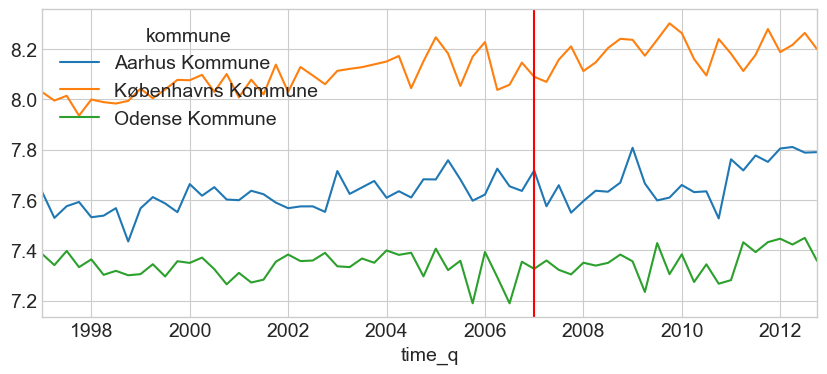

In [68]:
plot=temp_agg['ln_price'].unstack().plot()
plot.axvline(x=pd.Period('2007Q1'), color='r')

In [30]:
df_final['ln_price']=np.log(df_final['real_price_1000'])
df_final['ln_price']

2784     7.221864
2785     7.679313
2786     7.136966
2787     6.565179
2788     7.814110
           ...   
76732    7.273260
76733    7.886365
76734    7.652750
76735    8.091005
76736    6.787487
Name: ln_price, Length: 55541, dtype: float64

In [31]:
df_final['cph']=df_final.kommune.map({'Københavns Kommune': 1})
df_final['treat']=df_final.kommune.map({'Odense Kommune': 1, 'Aarhus Kommune':1, 'Københavns Kommune':0})
df_final['cph']=df_final['cph'].replace(np.nan, 0)
df_final['cph'].mean()

0.17714841288417565

In [32]:
df_final['treat'].mean()

0.8228515871158244

In [33]:
df_final['year2']=df_final['year']
df_final=pd.get_dummies(df_final, columns=['year'])

In [34]:
df_final['year']=df_final['year2']

In [35]:
df_final['post']=df_final['time_q']>='2007Q1'
df_final['post']=df_final['post'].astype(int)
df_final['post_x_treat']=df_final['post']*df_final['treat']

In [36]:
all_year_dummies=df_final.columns[[x.startswith('year_') for x in df_final.columns]]
year_dummies=list(all_year_dummies[2:]) # get all columns with year dummies, base year 1997
treat = ['treat', 'post', 'post_x_treat']
x_list = treat.extend(year_dummies)

In [37]:
copy_=df_final.copy()

In [38]:
treat

['treat',
 'post',
 'post_x_treat',
 'year_1998',
 'year_1999',
 'year_2000',
 'year_2001',
 'year_2002',
 'year_2003',
 'year_2004',
 'year_2005',
 'year_2006',
 'year_2007',
 'year_2008',
 'year_2009',
 'year_2010',
 'year_2011',
 'year_2012']

In [39]:
y=df_final['ln_price'].values
x=df_final[treat].values

In [46]:
df_final['ln_price'][df_final['kommune']=='Københavns Kommune']

27844    8.476492
27845    6.765099
27846    6.988243
27847    7.749422
27848    8.032047
           ...   
38459    8.214538
38460    7.982736
38461    8.305134
38462    8.356695
38463    9.176587
Name: ln_price, Length: 9839, dtype: float64

In [47]:
import matplotlib.dates as dates

In [55]:
x_dates = df_final['time_q'][df_final['kommune']=='Københavns Kommune']
x_num = dates.date2num(x_dates)

cph_trend=np.polyfit(x_num, df_final['ln_price'][df_final['kommune']=='Københavns Kommune'], 1)
cph_trend

array([4.01971396e-05, 7.60427383e+00])

In [53]:
np.poly1d(trend)


poly1d([-1.66178276e-05,  7.95895942e-01])

In [40]:
import statsmodels as sm
import statsmodels.formula.api as smf

In [44]:
formula = f"""ln_price ~ treat + post + post_x_treat + C(year) + C(kommune) + house_size_m2"""
mod1=smf.ols(formula=formula, data=df_final)
res=mod1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     776.4
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:46:21   Log-Likelihood:                -47157.
No. Observations:               55541   AIC:                         9.435e+04
Df Residuals:                   55521   BIC:                         9.453e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            4.9650      0.008    610.605      0.000       4.949       4.981
C(year)[T.1998]                     -0.0422      0.013     -3.365      0.001      -0.067      -0.018
C(year)[T.1999]                     -0.0070      0.013     -0.550      0.583      -0.032       0.018
C(year)[T.2000]                      0.0296      0.013      2.301      0.021       0.004       0.055
C(year)[T.2001]                      0.0078      0.013      0.595      0.552      -0.018       0.034
C(year)[T.2002]                      0.0126      0.013      0.982      0.326      -0.012       0.038
C(year)[T.2003]                      0.0594      0.013      4.660      0.000       0.034       0.084
C(year)[T.2004]                      0.0482      0.013      3.818      0.000       0.023       0.073
C(year)[T.2005]                      0.0555      0.012      4.502      0.000       0.031       0.080
C(year)[T.2006]                      0.0248      0.013      1.906      0.057      -0.001       0.050
C(year)[T.2007]                     -0.0279      0.009     -3.022      0.003      -0.046      -0.010
C(year)[T.2008]                     -0.0108      0.010     -1.048      0.294      -0.031       0.009
C(year)[T.2009]                      0.0130      0.010      1.274      0.203      -0.007       0.033
C(year)[T.2010]                     -0.0365      0.009     -4.008      0.000      -0.054      -0.019
C(year)[T.2011]                      0.0639      0.010      6.210      0.000       0.044       0.084
C(year)[T.2012]                      0.1010      0.010     10.191      0.000       0.082       0.120
C(kommune)[T.Københavns Kommune]     2.7369      0.006    461.778      0.000       2.725       2.749
C(kommune)[T.Odense Kommune]        -0.2730      0.005    -50.717      0.000      -0.284      -0.262
treat                                2.2281      0.006    404.412      0.000       2.217       2.239
post                                 0.1027      0.013      8.158      0.000       0.078       0.127
post_x_treat                        -0.0609      0.013     -4.523      0.000      -0.087      -0.034
house_size_m2                        0.0026   5.55e-05     47.181      0.000       0.003       0.003
==============================================================================
Omnibus:                    20267.678   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           171867.074
Skew:                          -1.523   Prob(JB):                         0.00
Kurtosis:                      11.062   Cond. No.                     4.04e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is corre

In [42]:
formula = f"""ln_price ~ treat + post + C(kommune):post_x_treat:C(year) + C(year) + C(kommune)"""
mod2=smf.ols(formula=formula, data=df_final)
res2=mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     417.2
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:42:20   Log-Likelihood:                -48225.
No. Observations:               55541   AIC:                         9.651e+04
Df Residuals:                   55511   BIC:                         9.678e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  4.964e+10   3.64e+11      0.136      0.892   -6.64e+11    7.63e+11
C(year)[T.1998]                                              -0.0418      0.014     -2.902      0.004      -0.070      -0.014
C(year)[T.1999]                                              -0.0039      0.015     -0.267      0.789      -0.033       0.025
C(year)[T.2000]                                               0.0306      0.015      2.050      0.040       0.001       0.060
C(year)[T.2001]                                               0.0075      0.015      0.498      0.619      -0.022       0.037
C(year)[T.2002]                                               0.0124      0.015      0.833      0.405      -0.017       0.042
C(year)[T.2003]                                               0.0600      0.015      4.106      0.000       0.031       0.089
C(year)[T.2004]                                               0.0527      0.014      3.674      0.000       0.025       0.081
C(year)[T.2005]                                               0.0624      0.015      4.296      0.000       0.034       0.091
C(year)[T.2006]                                               0.0382      0.015      2.568      0.010       0.009       0.067
C(year)[T.2007]                                            1.562e+10    9.3e+10      0.168      0.867   -1.67e+11    1.98e+11
C(year)[T.2008]                                            1.562e+10    9.3e+10      0.168      0.867   -1.67e+11    1.98e+11
C(year)[T.2009]                                            1.562e+10    9.3e+10      0.168      0.867   -1.67e+11    1.98e+11
C(year)[T.2010]                                            1.562e+10    9.3e+10      0.168      0.867   -1.67e+11    1.98e+11
C(year)[T.2011]                                            1.562e+10    9.3e+10      0.168      0.867   -1.67e+11    1.98e+11
C(year)[T.2012]                                            1.562e+10    9.3e+10      0.168      0.867   -1.67e+11    1.98e+11
C(kommune)[T.Københavns Kommune]                          -4.964e+10   3.64e+11     -0.136      0.892   -7.63e+11    6.64e+11
C(kommune)[T.Odense Kommune]                                 -0.2780      0.007    -42.168      0.000      -0.291      -0.265
treat                                                     -4.964e+10   3.64e+11     -0.136      0.892   -7.63e+11    6.64e+11
post                                                      -1.562e+10    9.3e+10     -0.168      0.867   -1.98e+11    1.67e+11
C(kommune)[Aarhus Kommune]:post_x_treat:C(year)[1997]       8.49e+07   3.82e+08      0.223      0.824   -6.63e+08    8.33e+08
C(kommune)[Københavns Kommune]:post_x_treat:C(year)[1997] -

In [ ]:
smf.ols()

In [22]:
%%time
errors = []

def process_url(id_url_pair):
    id_, url = id_url_pair
    try:
        soup = get_soup(url, header, selenium=True, driver=driver)
        output = extract_info_boliga_bbr(soup)
        return id_, [url,output]
    except:
        print(f'Error encountered on url {url}')
        errors.append(url)
        pd.DataFrame(errors).to_csv
        return id_, None

id_url_pairs = [(id_, url) for id_, url in enumerate(list_of_bbr[:50000])]


for id_ in tqdm.tqdm(range(len(id_url_pairs))):
    id_, data = process_url(id_url_pairs[id_])
    df = pd.DataFrame(data)
    df=df.T
    df.columns = ['bbr_link', 'land_value']
    df.to_parquet(f'data/bbr/bbr_{id_}.pq')

 20%|█▉        | 9774/50000 [4:11:01<12:42:09,  1.14s/it]

In [143]:
temp=process_url(id_url_pairs[0])

In [146]:
id_, data = temp

In [147]:
data

['https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D59-AF2E-1C641F4BA09F#info-valueChanges',
 [('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2022'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2021'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2019'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2018'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2017'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2016'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2015'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2014'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2013'),
  ('Grundværdi  568.900\xa0kr.', 'Ændret  1. okt. 2012'),
  ('Grundværdi  568.900\xa0kr.', 'Ændret  1. okt. 2011'),
  ('Grundværdi  394.400\xa0kr.', 'Ændret  1. okt. 2010'),
  ('Grundværdi  394.400\xa0kr.', 'Ændret  1. okt. 2009'),
  ('Grundværdi  515.800\xa0kr.', 'Ændret  1. okt. 2008'),
  ('Grundværdi  515.800\xa0kr.', 'Ændret  1. okt. 2007'),
  ('Grundværdi  318.600\xa0kr.', 'Ændret 

In [129]:
save

[(0,
  ['https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D59-AF2E-1C641F4BA09F#info-valueChanges',
   [('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2022'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2021'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2019'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2018'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2017'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2016'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2015'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2014'),
    ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2013'),
    ('Grundværdi  568.900\xa0kr.', 'Ændret  1. okt. 2012'),
    ('Grundværdi  568.900\xa0kr.', 'Ændret  1. okt. 2011'),
    ('Grundværdi  394.400\xa0kr.', 'Ændret  1. okt. 2010'),
    ('Grundværdi  394.400\xa0kr.', 'Ændret  1. okt. 2009'),
    ('Grundværdi  515.800\xa0kr.', 'Ændret  1. okt. 2008'),
    ('Grundværdi  515.800\xa0kr.', 'Ændret  1. okt. 2007'),
    

In [ ]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(process_url, id_url_pairs), total=len(id_url_pairs)))

for result in results:
    id_, data = result
    if data is not None:
        df = pd.DataFrame(data)
        df = df.T
        df.columns=['bbr_link', 'land_value']
        df.to_parquet(f'data/bbr/bbr_{id_}.pq')

In [95]:
pair=[(id_, url) for id_, url in enumerate(list_of_bbr[:10])]

In [116]:
list((process_url, id_url_pairs))

[<function __main__.process_url(id_url_pair)>,
 [(0,
   'https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D59-AF2E-1C641F4BA09F#info-valueChanges'),
  (1,
   'https://www.boliga.dk/bbrinfo/1FDEA88C-AB6E-4514-9A8E-ACA21B076A79#info-valueChanges'),
  (2,
   'https://www.boliga.dk/bbrinfo/929C81F2-5EC6-40B5-AE72-1EFA4750A62E#info-valueChanges'),
  (3,
   'https://www.boliga.dk/bbrinfo/54F72ED9-39E7-4004-9266-5AC25DF22B3D#info-valueChanges'),
  (4,
   'https://www.boliga.dk/bbrinfo/80CB7122-1BB6-4D81-9311-E370C69FE439#info-valueChanges'),
  (5,
   'https://www.boliga.dk/bbrinfo/7BD09520-E2C7-4EEF-906E-8A8BDD9245DC#info-valueChanges'),
  (6,
   'https://www.boliga.dk/bbrinfo/9E361121-1902-4C89-B5CD-07116040EAFB#info-valueChanges'),
  (7,
   'https://www.boliga.dk/bbrinfo/52C89739-BAD1-48E4-A1F2-3401B1D405B9#info-valueChanges'),
  (8,
   'https://www.boliga.dk/bbrinfo/DE94A86F-61A3-4A53-B83F-F772D3B90DBD#info-valueChanges'),
  (9,
   'https://www.boliga.dk/bbrinfo/19883EFD-7FA0-4E17-98A3-44670A4

In [119]:
%%time


CPU times: total: 859 ms
Wall time: 11.2 s


In [123]:
save[2]

(2,
 ['https://www.boliga.dk/bbrinfo/929C81F2-5EC6-40B5-AE72-1EFA4750A62E#info-valueChanges',
  [('Grundværdi  410.700\xa0kr.', 'Ændret  1. okt. 2022'),
   ('Grundværdi  410.700\xa0kr.', 'Ændret  1. okt. 2021'),
   ('Grundværdi  410.700\xa0kr.', 'Ændret  1. okt. 2019'),
   ('Grundværdi  410.700\xa0kr.', 'Ændret  1. okt. 2018'),
   ('Grundværdi  410.700\xa0kr.', 'Ændret  1. okt. 2017'),
   ('Grundværdi  454.500\xa0kr.', 'Ændret  1. okt. 2016'),
   ('Grundværdi  454.500\xa0kr.', 'Ændret  1. okt. 2015'),
   ('Grundværdi  454.500\xa0kr.', 'Ændret  1. okt. 2014'),
   ('Grundværdi  454.500\xa0kr.', 'Ændret  1. okt. 2013'),
   ('Grundværdi  466.200\xa0kr.', 'Ændret  1. okt. 2012'),
   ('Grundværdi  466.200\xa0kr.', 'Ændret  1. okt. 2011'),
   ('Grundværdi  349.700\xa0kr.', 'Ændret  1. okt. 2010'),
   ('Grundværdi  349.700\xa0kr.', 'Ændret  1. okt. 2009'),
   ('Grundværdi  466.200\xa0kr.', 'Ændret  1. okt. 2008'),
   ('Grundværdi  466.200\xa0kr.', 'Ændret  1. okt. 2007'),
   ('Grundværdi  252.

In [38]:
df

,bbr_link,land_value
0,https://www.boliga.dk/bbrinfo/CC99597C-FE4B-4D...,"[(Grundværdi 473.600 kr., Ændret 1. okt. 202..."


In [99]:
list_of_bbr[20]

'https://www.boliga.dk/bbrinfo/8251B121-D2B5-4B30-A292-E851EAA5158F#info-valueChanges'

In [110]:
results[5]

(5,
 ['https://www.boliga.dk/bbrinfo/7BD09520-E2C7-4EEF-906E-8A8BDD9245DC#info-valueChanges',
  [[('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2022'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2021'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2019'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2018'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2017'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2016'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2015'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2014'),
    ('Grundværdi  690.800\xa0kr.', 'Ændret  1. okt. 2013'),
    ('Grundværdi  708.500\xa0kr.', 'Ændret  1. okt. 2012'),
    ('Grundværdi  708.500\xa0kr.', 'Ændret  1. okt. 2011'),
    ('Grundværdi  598.900\xa0kr.', 'Ændret  1. okt. 2010'),
    ('Grundværdi  598.900\xa0kr.', 'Ændret  1. okt. 2009'),
    ('Grundværdi  674.800\xa0kr.', 'Ændret  1. okt. 2008'),
    ('Grundværdi  674.800\xa0kr.', 'Ændret  1. okt. 2007'),
    ('

In [75]:
pd.read_parquet('data/bbr/bbr_0.pq')['bbr_link'][0]

'https://www.boliga.dk/bbrinfo/8251B121-D2B5-4B30-A292-E851EAA5158F#info-valueChanges'

In [83]:
pd.read_parquet('data/bbr/bbr_12.pq')['land_value'][0]

array([array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2022'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2021'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2019'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2018'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2017'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2016'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2015'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2014'], dtype=object),
       array(['Grundværdi  473.600\xa0kr.', 'Ændret  1. okt. 2013'], dtype=object),
       array(['Grundværdi  485.700\xa0kr.', 'Ændret  1. okt. 2012'], dtype=object),
       array(['Grundværdi  485.700\xa0kr.', 'Ændret  1. okt. 2011'], dtype=object),
       array(['Grundværdi  348.100\xa0kr.', 'Ændret  1. okt. 2010'], dtype=o

In [82]:
soup=get_soup(url,header=header, selenium=True, driver=driver)
output=extract_info_boliga_bbr(soup)

In [79]:
[url,output]

['https://www.boliga.dk/bbrinfo/A7ACE50C-94F6-4D59-AF2E-1C641F4BA09F#info-valueChanges',
 [('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2022'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2021'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2019'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2018'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2017'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2016'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2015'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2014'),
  ('Grundværdi  554.700\xa0kr.', 'Ændret  1. okt. 2013'),
  ('Grundværdi  568.900\xa0kr.', 'Ændret  1. okt. 2012'),
  ('Grundværdi  568.900\xa0kr.', 'Ændret  1. okt. 2011'),
  ('Grundværdi  394.400\xa0kr.', 'Ændret  1. okt. 2010'),
  ('Grundværdi  394.400\xa0kr.', 'Ændret  1. okt. 2009'),
  ('Grundværdi  515.800\xa0kr.', 'Ændret  1. okt. 2008'),
  ('Grundværdi  515.800\xa0kr.', 'Ændret  1. okt. 2007'),
  ('Grundværdi  318.600\xa0kr.', 'Ændret 

In [53]:
pd.read_parquet('data/frontpage/boliga_1.pq')

,link,bbr_link,address,price,date_of_sale,type_of_sale,house_size_m2,house_price_per_m2,no_of_rooms,year_built
0,https://www.boliga.dk/salg/info/621/201217/5BF...,https://www.boliga.dk/bbrinfo/5BFBC165-4E64-44...,Christianshave 31 6000 Kolding,560.000 kr.,05-11-1974,Alm. Salg,155 m²,3.613 kr/m²,5,2015
1,https://www.boliga.dk/salg/info/430/20036/A35B...,https://www.boliga.dk/bbrinfo/A35B1617-43AA-43...,Rønnebærvænget 5B 5856 Ryslinge,268.000 kr.,14-11-1985,Alm. Salg,63 m²,4.254 kr/m²,2,1978
2,https://www.boliga.dk/salg/info/860/3278/76D17...,https://www.boliga.dk/bbrinfo/76D17D74-9E4D-43...,de Plessenvej 15 9850 Hirtshals,116.400 kr.,13-01-1986,Fam. Salg,93 m²,1.252 kr/m²,4,1985
3,https://www.boliga.dk/salg/info/707/112163/DA0...,https://www.boliga.dk/bbrinfo/DA030E60-4C83-46...,Fasanvej 27 8950 Ørsted,52.750 kr.,14-07-1987,Fam. Salg,109 m²,484 kr/m²,4,1987
4,https://www.boliga.dk/salg/info/101/40300/519B...,https://www.boliga.dk/bbrinfo/519BD5E8-11CF-48...,"Ottilia Jacobsens Plads 17, 2. th 1799 Københ...",3.580.136 kr.,05-12-1987,Alm. Salg,82 m²,43.660 kr/m²,3,2020
5,https://www.boliga.dk/salg/info/707/110547/38E...,https://www.boliga.dk/bbrinfo/38E98D16-E36B-4C...,Sandagervej 2A 8961 Allingåbro,84.893 kr.,31-03-1990,Andet,60 m²,1.415 kr/m²,2,1942
6,https://www.boliga.dk/salg/info/360/9329/5653D...,https://www.boliga.dk/bbrinfo/5653DFEA-FBB9-43...,Bekkasinvej 10 4930 Maribo,585.000 kr.,31-12-1991,Fam. Salg,130 m²,4.500 kr/m²,4,1981
7,https://www.boliga.dk/salg/info/461/123260/99B...,https://www.boliga.dk/bbrinfo/99B3004D-BD56-42...,Fraugde-Kærby-Vej 84 5220 Odense SØ,572.200 kr.,31-12-1991,Fam. Salg,200 m²,2.861 kr/m²,5,1900
8,https://www.boliga.dk/salg/info/621/49240/F2E8...,https://www.boliga.dk/bbrinfo/F2E8ACB0-C017-42...,Fåborgvej 4 6000 Kolding,785.000 kr.,31-12-1991,Fam. Salg,152 m²,5.164 kr/m²,5,1973
9,https://www.boliga.dk/salg/info/330/8263/8C96F...,https://www.boliga.dk/bbrinfo/8C96F17D-5A93-46...,Lyrekrogen 18 4220 Korsør,75.840 kr.,31-12-1991,Alm. Salg,91 m²,833 kr/m²,6,1969
